In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from gensim.models.phrases import Phrases, Phraser
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import numpy as np
import tensorflow as tf
np.random.seed(999)
tf.random.set_seed(999)

# Load DataFrame (replace with your actual data, e.g., BloombergNews100.csv)
# Load the dataset
df = pd.read_csv('data/News Articles/Kraggle Datasets/Labeled-headlines (Kraggle).csv', encoding='ISO-8859-1', on_bad_lines='skip', header=None)
df = df.dropna()

# Define a function to preprocess the text
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text.lower())  # Tokenize and convert to lowercase
    tokens = [word for word in tokens if word.isalpha()]  # Remove non-alphabetic characters
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return tokens

# Apply the function to preprocess the 'data' column
df['processed_content'] = df[1].apply(preprocess_text)

df = pd.DataFrame({
    'processed_content': df['processed_content'],
    'sentiment': df[0]
})

df.head()

# Apply bigram/trigram preprocessing
bigram_model = Phrases(df['processed_content'], min_count=1, threshold=10)
trigram_model = Phrases(bigram_model[df['processed_content']], min_count=1, threshold=10)
bigram_phraser = Phraser(bigram_model)
trigram_phraser = Phraser(trigram_model)
df['processed_content_phrased'] = df['processed_content'].apply(
    lambda x: trigram_phraser[bigram_phraser[x]]
)

# Convert sentiment labels to numerical (if not already)
label_map = {'neutral': 1, 'none': 1, 'positive': 2, 'negative': 0}
if df['sentiment'].dtype == 'object':
    df['sentiment'] = df['sentiment'].map(label_map)

# Split data
X = df['processed_content_phrased']
y = df['sentiment']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 3392, Val: 974, Test: 480


In [2]:
# 2. ANN + TF-IDF Model with Custom Vocabulary

from tensorflow.keras.utils import to_categorical
from sklearn.feature_extraction.text import TfidfVectorizer

positive_terms = [
    'profit', 'rose', 'increased', 'increase', 'agreement', 'signed', 'contract',
    'growth', 'grew', 'awarded', 'positive', 'operating profit', 'net profit',
    'profit rose', 'period increased', 'sales increased', 'signed agreement',
    'increased respectively', 'loss narrowed', 'pretax profit', 'profit period',
    'sales rose', 'profit net', 'grew percent', 'awarded contract', 'sales increase',
    'profit increased', 'cost savings', 'expected increase', 'profit totalled',
    'operating profit rose', 'net profit rose', 'period increased revenue',
    'increased respectively compared', 'net sales increased', 'sales period increased',
    'operating profit net', 'profit net sales', 'today net profit', 'sales rose net',
    'operating profit increased', 'net sales rose', 'net sales increase',
    'said net profit', 'operating profit totalled', 'operating profit period',
    'grew percent million'
]

negative_terms = [
    'loss', 'decreased', 'fell', 'lower', 'cut', 'dropped', 'negative',
    'declined', 'warning', 'laid', 'decreased eur', 'operating loss',
    'net loss', 'profit fell', 'sales decreased', 'profit decreased',
    'profit warning', 'loss totalled', 'pct lower', 'period decreased',
    'pretax loss', 'today slipped', 'sales fell', 'slipped net',
    'personnel reductions', 'fell percent', 'loss totaled', 'decreased net',
    'laid off', 'operating profit fell', 'profit period decreased',
    'operating loss totalled', 'period decreased net', 'net sales decreased',
    'said today slipped', 'decreased net sales', 'net profit decreased',
    'slipped net loss', 'issued profit warning', 'net profit fell',
    'operating profit decreased', 'today slipped net'
]

vocabulary = positive_terms + negative_terms

# Normalize terms for TF-IDF (replace underscores with spaces if needed)
vocabulary = [term.replace('_', ' ') for term in vocabulary]

# Using your exact TF-IDF setup
vectorizer = TfidfVectorizer(
    vocabulary=vocabulary,
    ngram_range=(1, 3),  # Changed from (0,3) to (1,3) as (0,3) is invalid
    lowercase=False
)

# Convert text to TF-IDF features using your phrased content
X_train_tfidf = vectorizer.fit_transform([' '.join(x) for x in X_train])
X_val_tfidf = vectorizer.transform([' '.join(x) for x in X_val])
X_test_tfidf = vectorizer.transform([' '.join(x) for x in X_test])
print("TF-IDF shape:", X_train_tfidf.shape)

# Convert labels to numerical format using your label_map
# Note: Using your label_map {'neutral':1, 'none':1, 'positive':2, 'negative':0}
y_train_enc = y_train.values
y_val_enc = y_val.values
y_test_enc = y_test.values

# One-hot encode labels
num_classes = 3  # For your 3 classes (0:negative, 1:neutral, 2:positive)
y_train_onehot = to_categorical(y_train_enc, num_classes=num_classes)
y_val_onehot = to_categorical(y_val_enc, num_classes=num_classes)
y_test_onehot = to_categorical(y_test_enc, num_classes=num_classes)

# ANN with Your Custom TF-IDF Features

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping

def build_ann_tfidf(input_dim):
    model = Sequential([
        Dense(256, activation='relu', input_dim=input_dim),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

ann_tfidf = build_ann_tfidf(X_train_tfidf.shape[1])
ann_tfidf.summary()

# Train ANN
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history_ann = ann_tfidf.fit(
    X_train_tfidf.toarray(), y_train_onehot,
    validation_data=(X_val_tfidf.toarray(), y_val_onehot),
    epochs=20,
    batch_size=32,
    # callbacks=[early_stop],
    verbose=1
)

TF-IDF shape: (3392, 89)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               23040     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 16)                1040      
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dropout_1 (Dropout)         (N

In [3]:
# 2. Normal ANN

from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding

# Convert text to word counts
vectorizer = CountVectorizer(max_features=5000)  # Keep top 5,000 words
X_train_bow = vectorizer.fit_transform([' '.join(x) for x in X_train]).toarray()
X_test_bow = vectorizer.transform([' '.join(x) for x in X_test]).toarray()

# Your exact ANN architecture
model = Sequential([
    Dense(128, input_dim=X_train_bow.shape[1], activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(3, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_bow, y_train_onehot, epochs=20, batch_size=32)

Epoch 1/20
106/106 [==============================] - 1s 4ms/step - loss: 0.9382 - accuracy: 0.5905
Epoch 2/20
106/106 [==============================] - 0s 4ms/step - loss: 0.6905 - accuracy: 0.6221
Epoch 3/20
106/106 [==============================] - 0s 4ms/step - loss: 0.4116 - accuracy: 0.8387
Epoch 4/20
106/106 [==============================] - 0s 4ms/step - loss: 0.1240 - accuracy: 0.9546
Epoch 5/20
106/106 [==============================] - 0s 4ms/step - loss: 0.0434 - accuracy: 0.9838
Epoch 6/20
106/106 [==============================] - 0s 4ms/step - loss: 0.0269 - accuracy: 0.9900
Epoch 7/20
106/106 [==============================] - 0s 4ms/step - loss: 0.0201 - accuracy: 0.9929
Epoch 8/20
106/106 [==============================] - 0s 4ms/step - loss: 0.0155 - accuracy: 0.9950
Epoch 9/20
106/106 [==============================] - 0s 4ms/step - loss: 0.0155 - accuracy: 0.9938
Epoch 10/20
106/106 [==============================] - 0s 4ms/step - loss: 0.0145 - accuracy: 0.9953

In [4]:
# Glove

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts([' '.join(x) for x in X_train])
vocab_size = len(tokenizer.word_index) + 1

# Sequence padding
max_len = 100  # Adjust based on your data
X_train_seq = pad_sequences(tokenizer.texts_to_sequences([' '.join(x) for x in X_train]), maxlen=max_len)
X_val_seq = pad_sequences(tokenizer.texts_to_sequences([' '.join(x) for x in X_val]), maxlen=max_len)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences([' '.join(x) for x in X_test]), maxlen=max_len)

# Load GloVe embeddings (download from https://nlp.stanford.edu/projects/glove/)
embedding_dim = 100
embeddings_index = {}
with open('data/Results Charts Models/Dictionaries/glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [5]:
# Build LSTM model
model_lstm = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
              input_length=max_len, trainable=False),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_lstm.summary()

# Train
history_lstm = model_lstm.fit(
    X_train_seq, y_train_onehot,
    validation_data=(X_val_seq, y_val_onehot),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          718800    
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 100)         0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 3)                

15/15 [==============================] - 0s 1ms/step

TF-IDF + ANN Evaluation:
Accuracy: 0.5979
Classification Report:
              precision    recall  f1-score   support

    negative       0.67      0.09      0.16        64
     neutral       0.60      0.96      0.74       275
    positive       0.61      0.12      0.20       141

    accuracy                           0.60       480
   macro avg       0.62      0.39      0.37       480
weighted avg       0.61      0.60      0.50       480



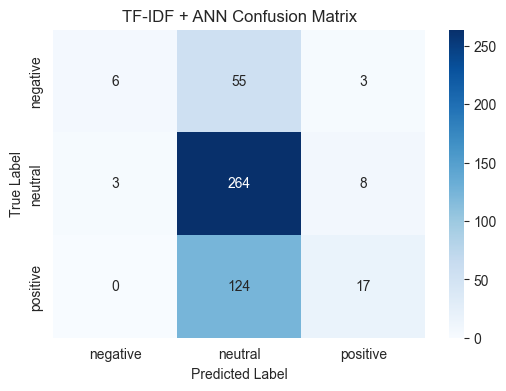

15/15 [==============================] - 0s 2ms/step

BoW + ANN Evaluation:
Accuracy: 0.6667
Classification Report:
              precision    recall  f1-score   support

    negative       0.59      0.36      0.45        64
     neutral       0.72      0.84      0.78       275
    positive       0.54      0.46      0.50       141

    accuracy                           0.67       480
   macro avg       0.62      0.55      0.57       480
weighted avg       0.65      0.67      0.65       480



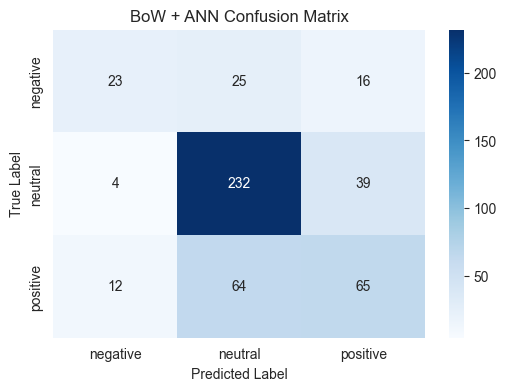

15/15 [==============================] - 1s 20ms/step

GloVe + LSTM Evaluation:
Accuracy: 0.7604
Classification Report:
              precision    recall  f1-score   support

    negative       0.67      0.48      0.56        64
     neutral       0.78      0.90      0.84       275
    positive       0.74      0.62      0.67       141

    accuracy                           0.76       480
   macro avg       0.73      0.67      0.69       480
weighted avg       0.75      0.76      0.75       480



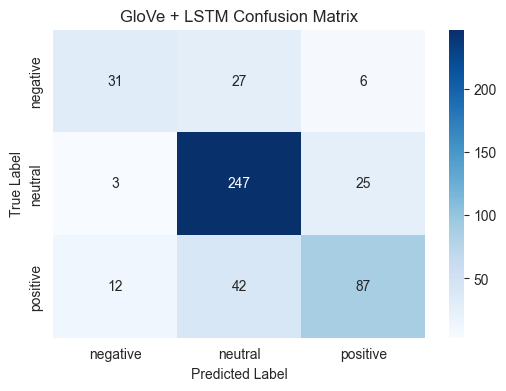

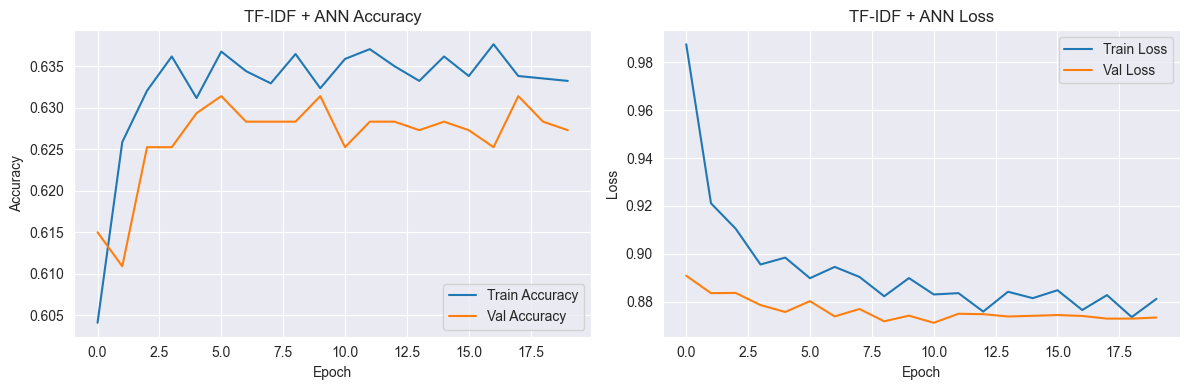

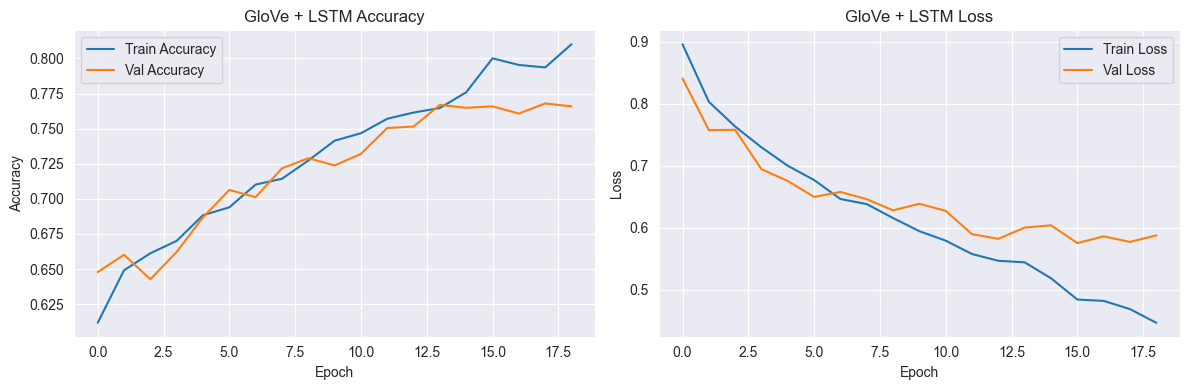

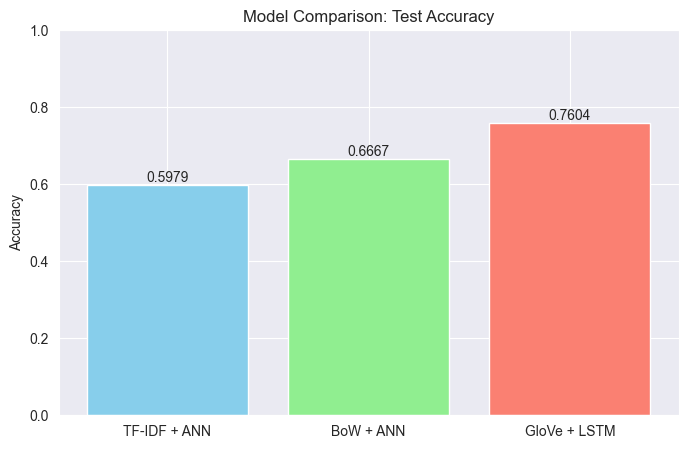


Top 20 Important Features (TF-IDF model):
adams: 0.0976
adding: 0.0887
abb: 0.0879
ability: 0.0858
accordance: 0.0853
access: 0.0812
activities: 0.0770
added: 0.0770
accessories: 0.0750
actual_agreement: 0.0739
administration: 0.0738
add: 0.0729
accounted_net_sales: 0.0713
adjust_operations: 0.0710
abroad: 0.0704
acquired_teleste: 0.0697
actively: 0.0696
accounts: 0.0693
advantage: 0.0692
active: 0.0689


In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

def evaluate_model(model, X_test, y_test, model_name, is_sequence=False):
    """Evaluate model and return metrics"""
    # Predict
    if is_sequence:
        y_pred = model.predict(X_test).argmax(axis=1)
    else:
        if hasattr(X_test, 'toarray'):
            X_test = X_test.toarray()
        y_pred = model.predict(X_test).argmax(axis=1)

    # Convert one-hot back to labels if needed
    if len(y_test.shape) > 1:
        y_test = y_test.argmax(axis=1)

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['negative', 'neutral', 'positive'])
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n{model_name} Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)

    # Plot confusion matrix
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['negative', 'neutral', 'positive'],
                yticklabels=['negative', 'neutral', 'positive'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return accuracy

# Evaluate all models
tfidf_acc = evaluate_model(ann_tfidf, X_test_tfidf, y_test_onehot, "TF-IDF + ANN")
bow_acc = evaluate_model(model, X_test_bow, y_test_onehot, "BoW + ANN")
glove_acc = evaluate_model(model_lstm, X_test_seq, y_test_onehot, "GloVe + LSTM", is_sequence=True)

# Training History Comparison
def plot_history(history, title):
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot training histories
plot_history(history_ann, "TF-IDF + ANN")
plot_history(history_lstm, "GloVe + LSTM")

# Final Comparison
models = ['TF-IDF + ANN', 'BoW + ANN', 'GloVe + LSTM']
accuracies = [tfidf_acc, bow_acc, glove_acc]

plt.figure(figsize=(8,5))
bars = plt.bar(models, accuracies, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Model Comparison: Test Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Add accuracy labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom')

plt.show()

# Print feature importance for TF-IDF model (top 20 features)
if hasattr(vectorizer, 'get_feature_names_out'):
    feature_names = vectorizer.get_feature_names_out()
    weights = ann_tfidf.layers[0].get_weights()[0]
    top_features = sorted(zip(feature_names, np.mean(np.abs(weights), axis=1)), key=lambda x: x[1], reverse=True)[:20]

    print("\nTop 20 Important Features (TF-IDF model):")
    for feature, weight in top_features:
        print(f"{feature}: {weight:.4f}")

In [7]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


# Enhanced LSTM Model with Regularization
def build_enhanced_lstm():
    model = Sequential([
        Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                 input_length=max_len, trainable=False),
        SpatialDropout1D(0.3),
        Bidirectional(LSTM(128, return_sequences=True,
                         kernel_regularizer=l2(0.01),
                         recurrent_dropout=0.2)),
        Bidirectional(LSTM(64, kernel_regularizer=l2(0.01))),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')]
    )
    return model

# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=3)
]

# Build and train enhanced model
enhanced_lstm = build_enhanced_lstm()
enhanced_lstm.summary()

history_enhanced = enhanced_lstm.fit(
    X_train_seq, y_train_onehot,
    validation_data=(X_val_seq, y_val_onehot),
    epochs=30,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          718800    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 100, 100)         0         
 lDropout1D)                                                     
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 256)         234496    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                      

15/15 [==============================] - 1s 38ms/step

ORIGINAL GLOVE+LSTM EVALUATION

Accuracy: 0.7604

Classification Report:
              precision    recall  f1-score   support

    negative       0.67      0.48      0.56        64
     neutral       0.78      0.90      0.84       275
    positive       0.74      0.62      0.67       141

    accuracy                           0.76       480
   macro avg       0.73      0.67      0.69       480
weighted avg       0.75      0.76      0.75       480



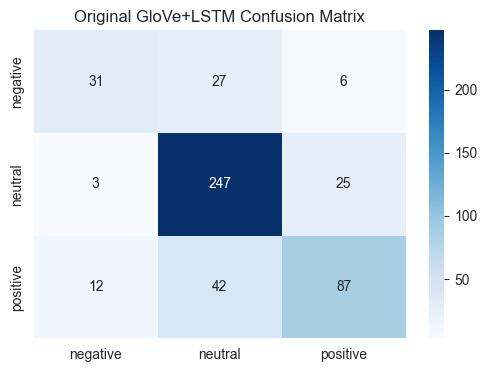


Class-wise Performance:

NEGATIVE CLASS:
Precision: 0.6739
Recall: 0.4844
F1-Score: 0.5636

NEUTRAL CLASS:
Precision: 0.7816
Recall: 0.8982
F1-Score: 0.8359

POSITIVE CLASS:
Precision: 0.7373
Recall: 0.6170
F1-Score: 0.6718
15/15 [==============================] - 4s 66ms/step

ENHANCED GLOVE+LSTM EVALUATION

Accuracy: 0.7000

Classification Report:
              precision    recall  f1-score   support

    negative       0.57      0.36      0.44        64
     neutral       0.72      0.92      0.81       275
    positive       0.67      0.43      0.52       141

    accuracy                           0.70       480
   macro avg       0.66      0.57      0.59       480
weighted avg       0.69      0.70      0.68       480



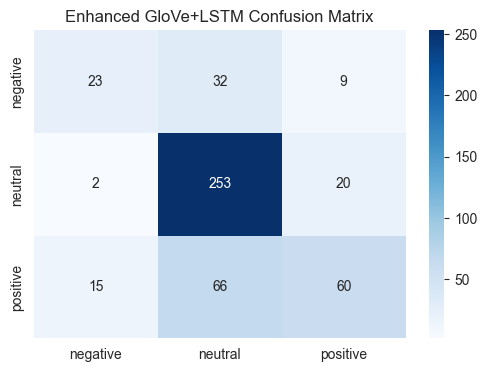


Class-wise Performance:

NEGATIVE CLASS:
Precision: 0.5750
Recall: 0.3594
F1-Score: 0.4423

NEUTRAL CLASS:
Precision: 0.7208
Recall: 0.9200
F1-Score: 0.8083

POSITIVE CLASS:
Precision: 0.6742
Recall: 0.4255
F1-Score: 0.5217


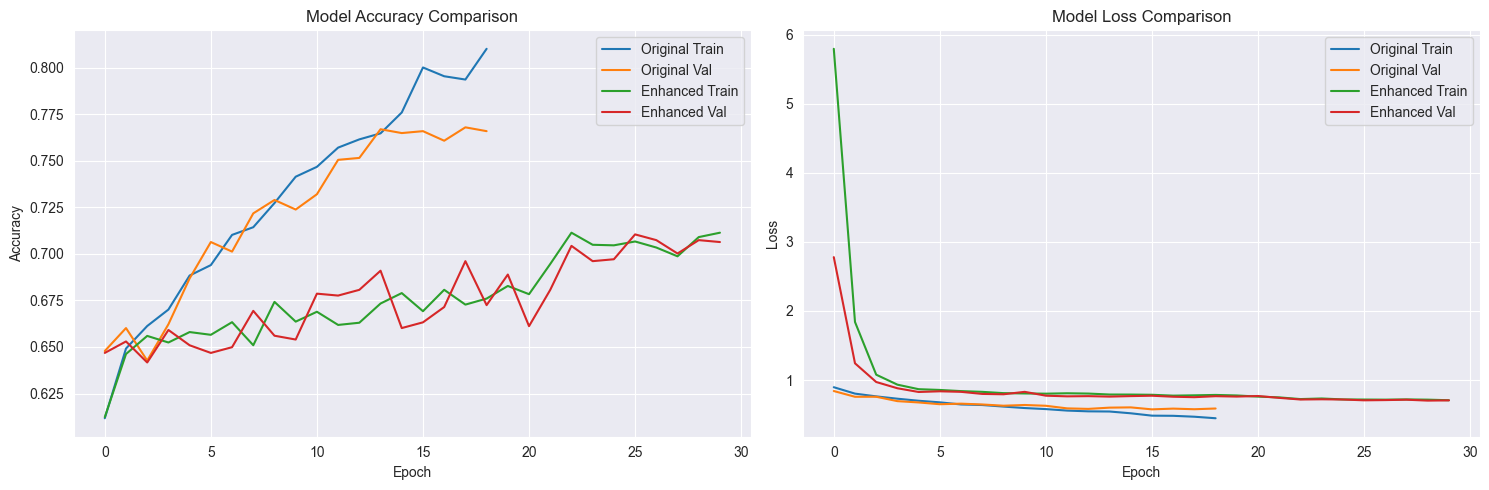

15/15 [==============================] - 1s 73ms/step

Final Comparison Table:
| Model               |   Test Accuracy | Training Time (per epoch)   |
|:--------------------|----------------:|:----------------------------|
| Original GloVe+LSTM |        0.760417 | N/A                         |
| Enhanced GloVe+LSTM |        0.7      | N/A                         |


In [8]:
# Evaluation function with additional metrics

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

def full_evaluation(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test).argmax(axis=1)
    y_true = y_test.argmax(axis=1)

    print(f"\n{'='*50}\n{model_name.upper()} EVALUATION\n{'='*50}")

    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"\nAccuracy: {acc:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['negative', 'neutral', 'positive']))

    # Confusion Matrix
    plt.figure(figsize=(6,4))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['negative', 'neutral', 'positive'],
               yticklabels=['negative', 'neutral', 'positive'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    # ROC Curve (for binary classification we'd use this)
    # For multi-class we can show precision-recall curves per class
    if num_classes == 3:
        print("\nClass-wise Performance:")
        for i, class_name in enumerate(['negative', 'neutral', 'positive']):
            print(f"\n{class_name.upper()} CLASS:")
            print(f"Precision: {precision_score(y_true, y_pred, average=None)[i]:.4f}")
            print(f"Recall: {recall_score(y_true, y_pred, average=None)[i]:.4f}")
            print(f"F1-Score: {f1_score(y_true, y_pred, average=None)[i]:.4f}")

# Compare original vs enhanced LSTM
full_evaluation(model_lstm, X_test_seq, y_test_onehot, "Original GloVe+LSTM")
full_evaluation(enhanced_lstm, X_test_seq, y_test_onehot, "Enhanced GloVe+LSTM")

# Training History Comparison
def plot_combined_history(original_hist, enhanced_hist):
    plt.figure(figsize=(15,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(original_hist.history['accuracy'], label='Original Train')
    plt.plot(original_hist.history['val_accuracy'], label='Original Val')
    plt.plot(enhanced_hist.history['accuracy'], label='Enhanced Train')
    plt.plot(enhanced_hist.history['val_accuracy'], label='Enhanced Val')
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(original_hist.history['loss'], label='Original Train')
    plt.plot(original_hist.history['val_loss'], label='Original Val')
    plt.plot(enhanced_hist.history['loss'], label='Enhanced Train')
    plt.plot(enhanced_hist.history['val_loss'], label='Enhanced Val')
    plt.title('Model Loss Comparison')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_combined_history(history_lstm, history_enhanced)

# Final Metrics Table
results = pd.DataFrame({
    'Model': ['Original GloVe+LSTM', 'Enhanced GloVe+LSTM'],
    'Test Accuracy': [
        accuracy_score(y_test_onehot.argmax(axis=1), model_lstm.predict(X_test_seq).argmax(axis=1)),
        accuracy_score(y_test_onehot.argmax(axis=1), enhanced_lstm.predict(X_test_seq).argmax(axis=1))
    ],
    'Training Time (per epoch)': [
        np.mean(history_lstm.history['time']) if 'time' in history_lstm.history else 'N/A',
        np.mean(history_enhanced.history['time']) if 'time' in history_enhanced.history else 'N/A'
    ]
})

print("\nFinal Comparison Table:")
print(results.to_markdown(index=False))

In [9]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

def build_optimized_lstm():
    model = Sequential([
        Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                 input_length=max_len, trainable=True),  # Now trainable!
        SpatialDropout1D(0.2),
        Bidirectional(LSTM(96, return_sequences=False,
                         kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))),
        Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Callbacks
optimized_callbacks = [
    EarlyStopping(patience=5, monitor='val_accuracy', mode='max', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
]

# Build and train
optimized_lstm = build_optimized_lstm()
optimized_lstm.summary()

history_optimized = optimized_lstm.fit(
    X_train_seq, y_train_onehot,
    validation_data=(X_val_seq, y_val_onehot),
    epochs=30,
    batch_size=32,  # Reduced from 64
    callbacks=optimized_callbacks,
    verbose=1
)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          718800    
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 100, 100)         0         
 lDropout1D)                                                     
                                                                 
 bidirectional_3 (Bidirectio  (None, 192)              151296    
 nal)                                                            
                                                                 
 dense_16 (Dense)            (None, 64)                12352     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 3)                

15/15 [==============================] - 0s 22ms/step

ORIGINAL GLOVE+LSTM EVALUATION

Accuracy: 0.7604

Classification Report:
              precision    recall  f1-score   support

    negative       0.67      0.48      0.56        64
     neutral       0.78      0.90      0.84       275
    positive       0.74      0.62      0.67       141

    accuracy                           0.76       480
   macro avg       0.73      0.67      0.69       480
weighted avg       0.75      0.76      0.75       480



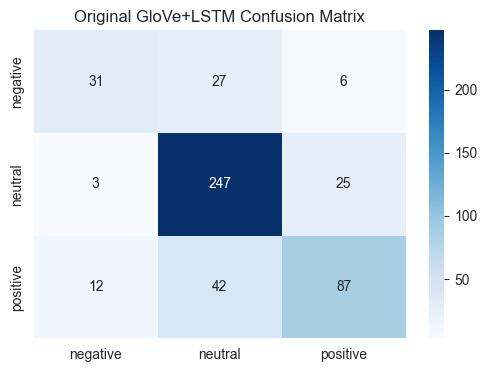


Class-wise Performance:

NEGATIVE CLASS:
Precision: 0.6739
Recall: 0.4844
F1-Score: 0.5636

NEUTRAL CLASS:
Precision: 0.7816
Recall: 0.8982
F1-Score: 0.8359

POSITIVE CLASS:
Precision: 0.7373
Recall: 0.6170
F1-Score: 0.6718
15/15 [==============================] - 1s 43ms/step

PREVIOUS ENHANCED EVALUATION

Accuracy: 0.7000

Classification Report:
              precision    recall  f1-score   support

    negative       0.57      0.36      0.44        64
     neutral       0.72      0.92      0.81       275
    positive       0.67      0.43      0.52       141

    accuracy                           0.70       480
   macro avg       0.66      0.57      0.59       480
weighted avg       0.69      0.70      0.68       480



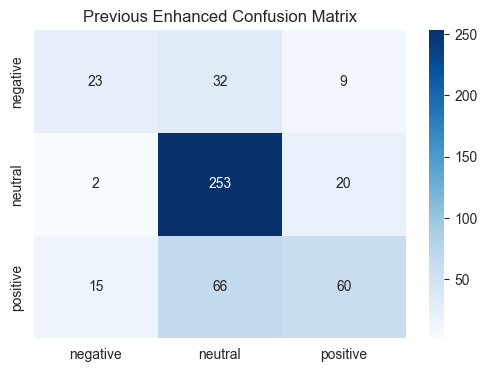


Class-wise Performance:

NEGATIVE CLASS:
Precision: 0.5750
Recall: 0.3594
F1-Score: 0.4423

NEUTRAL CLASS:
Precision: 0.7208
Recall: 0.9200
F1-Score: 0.8083

POSITIVE CLASS:
Precision: 0.6742
Recall: 0.4255
F1-Score: 0.5217
15/15 [==============================] - 1s 18ms/step

OPTIMIZED LSTM EVALUATION

Accuracy: 0.7542

Classification Report:
              precision    recall  f1-score   support

    negative       0.74      0.55      0.63        64
     neutral       0.81      0.83      0.82       275
    positive       0.66      0.70      0.68       141

    accuracy                           0.75       480
   macro avg       0.74      0.69      0.71       480
weighted avg       0.75      0.75      0.75       480



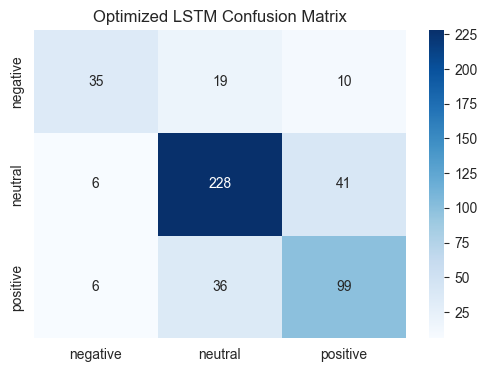


Class-wise Performance:

NEGATIVE CLASS:
Precision: 0.7447
Recall: 0.5469
F1-Score: 0.6306

NEUTRAL CLASS:
Precision: 0.8057
Recall: 0.8291
F1-Score: 0.8172

POSITIVE CLASS:
Precision: 0.6600
Recall: 0.7021
F1-Score: 0.6804


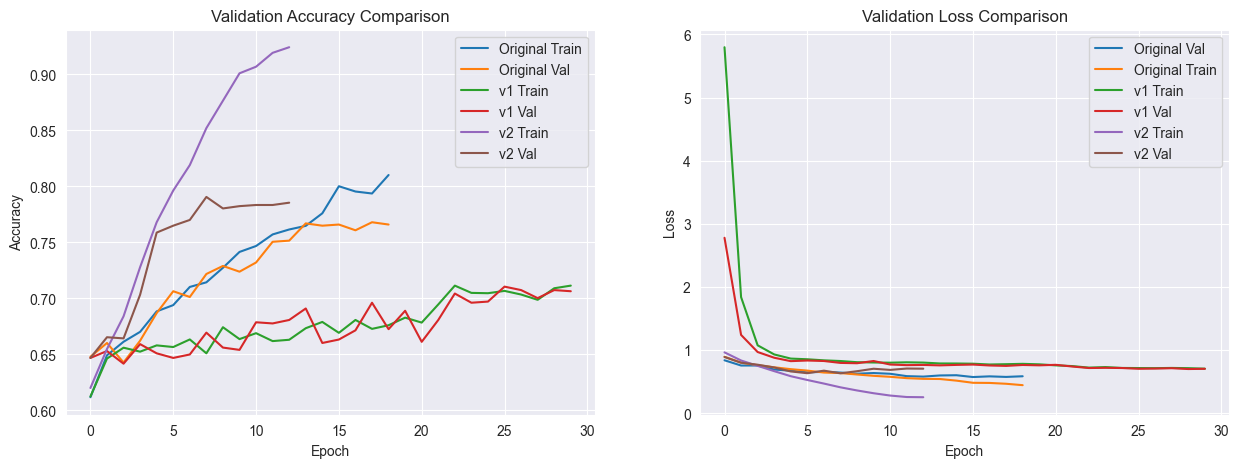

15/15 [==============================] - 0s 18ms/step

Final Comparison Table:
| Model               |   Test Accuracy | Training Time (per epoch)   |
|:--------------------|----------------:|:----------------------------|
| Original GloVe+LSTM |        0.760417 | N/A                         |
| Enhanced GloVe+LSTM |        0.7      | N/A                         |
| Optimized LSTM      |        0.754167 | N/A                         |


In [10]:
# Evaluate all three models

def full_evaluation(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test).argmax(axis=1)
    y_true = y_test.argmax(axis=1)

    print(f"\n{'='*50}\n{model_name.upper()} EVALUATION\n{'='*50}")

    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"\nAccuracy: {acc:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['negative', 'neutral', 'positive']))

    # Confusion Matrix
    plt.figure(figsize=(6,4))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['negative', 'neutral', 'positive'],
               yticklabels=['negative', 'neutral', 'positive'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    # ROC Curve (for binary classification we'd use this)
    # For multi-class we can show precision-recall curves per class
    if num_classes == 3:
        print("\nClass-wise Performance:")
        for i, class_name in enumerate(['negative', 'neutral', 'positive']):
            print(f"\n{class_name.upper()} CLASS:")
            print(f"Precision: {precision_score(y_true, y_pred, average=None)[i]:.4f}")
            print(f"Recall: {recall_score(y_true, y_pred, average=None)[i]:.4f}")
            print(f"F1-Score: {f1_score(y_true, y_pred, average=None)[i]:.4f}")


full_evaluation(model_lstm, X_test_seq, y_test_onehot, "Original GloVe+LSTM")
full_evaluation(enhanced_lstm, X_test_seq, y_test_onehot, "Previous Enhanced")
full_evaluation(optimized_lstm, X_test_seq, y_test_onehot, "Optimized LSTM")

def plot_combined_history(p1,p2,p3):


    # Training curves comparison
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)

    plt.plot(p1.history['accuracy'], label='Original Train')
    plt.plot(p1.history['val_accuracy'], label='Original Val')
    plt.plot(p2.history['accuracy'], label='v1 Train')
    plt.plot(p2.history['val_accuracy'], label='v1 Val')
    plt.plot(p3.history['accuracy'], label='v2 Train')
    plt.plot(p3.history['val_accuracy'], label='v2 Val')

    plt.title('Validation Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(p1.history['val_loss'], label='Original Val')
    plt.plot(p1.history['loss'], label='Original Train')
    plt.plot(p2.history['loss'], label='v1 Train')
    plt.plot(p2.history['val_loss'], label='v1 Val')
    plt.plot(p3.history['loss'], label='v2 Train')
    plt.plot(p3.history['val_loss'], label='v2 Val')

    plt.title('Validation Loss Comparison')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

plot_combined_history(history_lstm, history_enhanced, history_optimized)

# Final Metrics Table
results = pd.DataFrame({
    'Model': ['Original GloVe+LSTM', 'Enhanced GloVe+LSTM', 'Optimized LSTM'],
    'Test Accuracy': [
        accuracy_score(y_test_onehot.argmax(axis=1), model_lstm.predict(X_test_seq).argmax(axis=1)),
        accuracy_score(y_test_onehot.argmax(axis=1), enhanced_lstm.predict(X_test_seq).argmax(axis=1)),
        accuracy_score(y_test_onehot.argmax(axis=1), optimized_lstm.predict(X_test_seq).argmax(axis=1))
    ],
    'Training Time (per epoch)': [
        np.mean(history_lstm.history['time']) if 'time' in history_lstm.history else 'N/A',
        np.mean(history_enhanced.history['time']) if 'time' in history_enhanced.history else 'N/A',
        np.mean(history_optimized.history['time']) if 'time' in history_enhanced.history else 'N/A'
    ]
})

print("\nFinal Comparison Table:")
print(results.to_markdown(index=False))

In [11]:
optimized_lstm.save('data/Results Charts Models/Models/Optimized_LSTM (0.77 Acc).keras')

import pickle
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Assuming you have your original string labels (before one-hot encoding)
original_labels = ['negative', 'neutral', 'positive']  # Replace with your actual class names

# 1. Create and fit a LabelEncoder (if you haven't already)
le = LabelEncoder()
le.fit(original_labels)  # This creates the mapping

# 2. Save the complete label information
label_dict = {
    'classes': le.classes_.tolist(),  # Array of class names in order
    'mapping': dict(zip(le.classes_, range(len(le.classes_)))),  # Name to index
    'inverse_mapping': dict(zip(range(len(le.classes_)), le.classes_))  # Index to name
}

# 3. Save to file
with open('data/Results Charts Models/Models/optimised_lstm_label_dict.pkl', 'wb') as f:
    pickle.dump(label_dict, f)

# Save tokenizer
with open('data/Results Charts Models/Models/optimised_lstm_tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [17]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import LearningRateScheduler

def build_final_lstm():
    model = Sequential([
        Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=max_len,
            weights=[embedding_matrix],
            trainable=True,
            mask_zero=True  # Improved handling of padding
        ),
        SpatialDropout1D(0.3),  # Increased from 0.2
        Bidirectional(LSTM(
            128,  # Increased units
            return_sequences=False,
            kernel_regularizer=l1_l2(l1=1e-6, l2=1e-5),  # Reduced regularization
            recurrent_dropout=0.2  # Added recurrent dropout
        )),
        Dense(
            128,  # Increased capacity
            activation='relu',
            kernel_regularizer=l1_l2(l1=1e-6, l2=1e-5)
        ),
        Dropout(0.4),  # Slightly increased
        Dense(num_classes, activation='softmax')
    ])

    # Class weighting (focus more on negative class)
    class_weights = {0: 1.5, 1: 1, 2: 1}  # Negative 1.5x more important

    model.compile(
        optimizer=Adam(learning_rate=0.0003),  # Reduced learning rate
        loss='categorical_crossentropy',
        metrics=['accuracy',
                tf.keras.metrics.Precision(class_id=0, name='neg_precision'),
                tf.keras.metrics.Recall(class_id=0, name='neg_recall')],
        weighted_metrics=['accuracy']
    )
    return model, class_weights

In [18]:
# Custom learning rate schedule
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    return lr * tf.math.exp(-0.1)

enhanced_callbacks = [
    EarlyStopping(
        patience=7,  # Increased patience
        monitor='val_neg_recall',  # Focus on negative recall
        mode='max',
        restore_best_weights=True
    ),
    LearningRateScheduler(lr_scheduler),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )
]

# Build and train
enhanced_lstm, class_weights = build_enhanced_lstm()
enhanced_lstm.summary()

history = enhanced_lstm.fit(
    X_train_seq, y_train_onehot,
    validation_data=(X_val_seq, y_val_onehot),
    epochs=40,  # Increased epochs
    batch_size=64,
    callbacks=enhanced_callbacks,
    class_weight=class_weights,  # Apply class weights
    verbose=1
)

TypeError: cannot unpack non-iterable Sequential object

In [16]:
sentence = "Trump says China is an Bad Bad country"
processed_sentence = preprocess_text(sentence)

# Convert to sequence and pad
max_len = 100  # Should match your training sequence length
sequence = tokenizer.texts_to_sequences([' '.join(processed_sentence)])
padded_sequence = tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen=max_len, padding='post')

print(model_lstm.predict(padded_sequence))
print(enhanced_lstm.predict(padded_sequence))
print(optimized_lstm.predict(padded_sequence))

1/1 [==============================] - 0s 38ms/step
[[0.01993752 0.9514392  0.02862333]]
1/1 [==============================] - 0s 33ms/step
[[0.0499975  0.8397379  0.11026459]]
1/1 [==============================] - 0s 24ms/step
[[0.22294049 0.567764   0.20929553]]
